In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [5]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [6]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [7]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [8]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Investigating Whitening Methods

In [9]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [10]:
signal = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signal.append(sig)
    label.append(lbl["label"])
signal = torch.vstack(signal)
label = torch.stack(label)

  0%|          | 0/2592 [00:00<?, ?it/s]

In [11]:
signal.size(), label.size()

(torch.Size([2592, 22, 1, 1, 1001]), torch.Size([2592]))

In [12]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [13]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov

In [ ]:
x = signal.squeeze()
sig = x.permute(0, 2, 1)
x = torch.mean(sig, axis=1)
x_mean = torch.mean(x, axis=0)
sig.size(), x_mean.size()

In [ ]:
x = sig - x_mean
x_zero_centered = x.permute(0, 2, 1)
x_zero_centered.size()

In [ ]:
x = x_zero_centered
x_cov = calc_cov(x)
x_cov.shape

In [ ]:
plt.imshow(x_cov, cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
lda, V = torch.linalg.eig(x_cov)
lda, V = lda.real, V.real
whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
# print(torch.allclose(whitening_mat, torch.sqrt(torch.inverse(x_cov))))
# whitening_mat = torch.inverse(torch.sqrt(x_cov))

whitening_mat.size()

In [ ]:
plt.imshow(whitening_mat, cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
whitened_signal = whitening_mat @ x_zero_centered
whitened_signal.size()

In [ ]:
x = whitened_signal
whitened_signal_cov = calc_cov(x)
whitened_signal_cov.shape

In [ ]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

## Pytorch Dataset Transform Model

In [14]:
class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [15]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[3],
)

In [16]:
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [17]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds_w = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[3],
)

In [18]:
ds_w[0][0].size()

torch.Size([1, 22, 1, 1, 1001])

In [19]:
# train_dataset, _ = ds_w.get_train_test_subsets()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=1,
# )

batch_size = 32
train_dataset, val_dataset = ds_w.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

In [20]:
signal = []
for sig, lbl in tqdm(train_dataloader):
    signal.append(sig)
signal = torch.vstack(signal)
signal.size()

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([288, 22, 1, 1, 1001])

In [21]:
whitened_signal_cov = calc_cov(signal.squeeze())
whitened_signal_cov.shape

torch.Size([22, 22])

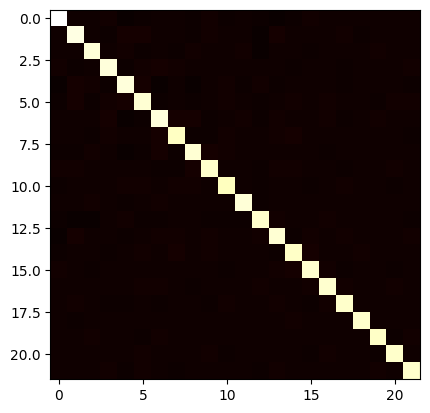

In [22]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

# Model

In [23]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

import torch.optim as optim

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [24]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [25]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [26]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [27]:
net = net.cuda()

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


9it [00:00, 14.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4163583781984117


Train -  [0.25, 0.0, 0.6872749485596709, 0.25, tensor(1.4216)]
Validation -  [0.25, 0.0, 0.6287776491769548, 0.25, tensor(1.4234)]

Epoch  1


9it [00:00, 23.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.424379375245836


Train -  [0.3368055555555556, 0.1157407407407407, 0.7749967849794238, 0.3368055555555556, tensor(1.4024)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.7501446759259259, 0.3333333333333333, tensor(1.4032)]

Epoch  2


9it [00:00, 14.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.400102588865492


Train -  [0.3263888888888889, 0.10185185185185186, 0.8110532407407407, 0.3263888888888889, tensor(1.3842)]
Validation -  [0.3229166666666667, 0.09722222222222221, 0.7850276491769548, 0.3229166666666667, tensor(1.3853)]

Epoch  3


9it [00:00, 15.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3851607905493841


Train -  [0.25, 0.0, 0.8521090534979424, 0.25, tensor(1.3891)]
Validation -  [0.25, 0.0, 0.8194605195473252, 0.25, tensor(1.3910)]

Epoch  4


9it [00:00, 22.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3845865329106648


Train -  [0.4236111111111111, 0.2314814814814815, 0.8292020318930041, 0.4236111111111111, tensor(1.3752)]
Validation -  [0.40625, 0.20833333333333337, 0.8020833333333334, 0.40625, tensor(1.3772)]

Epoch  5


9it [00:00, 29.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3697672817442152


Train -  [0.4583333333333333, 0.2777777777777778, 0.8478813014403292, 0.4583333333333333, tensor(1.3507)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.814477237654321, 0.4479166666666667, tensor(1.3538)]

Epoch  6


9it [00:00, 20.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3589338858922322


Train -  [0.3298611111111111, 0.10648148148148151, 0.8010866769547325, 0.3298611111111111, tensor(1.3411)]
Validation -  [0.3402777777777778, 0.12037037037037035, 0.7709297839506173, 0.3402777777777778, tensor(1.3440)]

Epoch  7


9it [00:00, 22.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.337949766053094


Train -  [0.40625, 0.20833333333333337, 0.8801440329218106, 0.40625, tensor(1.3292)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.8625739454732511, 0.4097222222222222, tensor(1.3339)]

Epoch  8


9it [00:00, 15.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3158889081743028


Train -  [0.4131944444444444, 0.21759259259259256, 0.8759002057613169, 0.4131944444444444, tensor(1.3046)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.8545203189300412, 0.4097222222222222, tensor(1.3106)]

Epoch  9


9it [00:00, 19.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2902463277180989


Train -  [0.6006944444444444, 0.46759259259259256, 0.9047550154320987, 0.6006944444444444, tensor(1.2635)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8708204732510288, 0.5868055555555556, tensor(1.2734)]

Epoch  10


9it [00:00, 17.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2689767281214397


Train -  [0.5347222222222222, 0.37962962962962965, 0.8803530092592592, 0.5347222222222222, tensor(1.2558)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.858619470164609, 0.4826388888888889, tensor(1.2711)]

Epoch  11


9it [00:00, 18.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2391640742619832


Train -  [0.6423611111111112, 0.5231481481481481, 0.9227430555555556, 0.6423611111111112, tensor(1.2019)]
Validation -  [0.6215277777777778, 0.49537037037037035, 0.8943383487654322, 0.6215277777777778, tensor(1.2228)]

Epoch  12


9it [00:00, 22.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1897552410761516


Train -  [0.625, 0.5, 0.923852237654321, 0.625, tensor(1.1765)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8987107767489712, 0.6006944444444444, tensor(1.2070)]

Epoch  13


9it [00:00, 26.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.165917820400662


Train -  [0.6701388888888888, 0.5601851851851851, 0.9321148405349794, 0.6701388888888888, tensor(1.1367)]
Validation -  [0.6458333333333334, 0.5277777777777778, 0.9124710648148149, 0.6458333333333334, tensor(1.1674)]

Epoch  14


9it [00:00, 16.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1253429253896077


Train -  [0.6354166666666666, 0.5138888888888888, 0.9441229423868314, 0.6354166666666666, tensor(1.1220)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.9197691615226338, 0.5347222222222222, tensor(1.1875)]

Epoch  15


9it [00:00, 20.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1020677751964993


Train -  [0.7916666666666666, 0.7222222222222222, 0.9526105967078189, 0.7916666666666666, tensor(1.0629)]
Validation -  [0.65625, 0.5416666666666667, 0.9298321759259258, 0.65625, tensor(1.1144)]

Epoch  16


9it [00:00, 24.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0621065960990057


Train -  [0.7222222222222222, 0.6296296296296297, 0.9562596450617284, 0.7222222222222222, tensor(1.0532)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.9271315586419753, 0.5972222222222222, tensor(1.1392)]

Epoch  17


9it [00:00, 16.57it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0531388653649225
Train -  [0.8055555555555556, 0.7407407407407407, 0.9584780092592593, 0.8055555555555556, tensor(1.0226)]
Validation -  [0.7048611111111112, 0.6064814814814814, 0.9328542952674896, 0.7048611111111112, tensor(1.0632)]

Epoch  18


9it [00:00, 18.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0543149246109857


Train -  [0.8368055555555556, 0.7824074074074074, 0.967480066872428, 0.8368055555555556, tensor(0.9923)]
Validation -  [0.7395833333333334, 0.6527777777777778, 0.9436406893004115, 0.7395833333333334, tensor(1.0450)]

Epoch  19


9it [00:00, 21.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0457995732625325


Train -  [0.7881944444444444, 0.7175925925925926, 0.9627539866255144, 0.7881944444444445, tensor(1.0297)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.9252668467078189, 0.5763888888888888, tensor(1.1576)]

Epoch  20


9it [00:00, 15.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9907829430368211


Train -  [0.7048611111111112, 0.6064814814814814, 0.9642007458847737, 0.7048611111111112, tensor(1.0215)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.9304108796296298, 0.5763888888888888, tensor(1.1303)]

Epoch  21


9it [00:00, 22.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9913693931367662


Train -  [0.8645833333333334, 0.8194444444444444, 0.974537037037037, 0.8645833333333333, tensor(0.9538)]
Validation -  [0.6875, 0.5833333333333333, 0.9430137602880658, 0.6875, tensor(1.0639)]

Epoch  22


9it [00:00, 20.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9766799940003289


Train -  [0.8923611111111112, 0.8564814814814815, 0.9784593621399177, 0.8923611111111112, tensor(0.9281)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9534786522633745, 0.7708333333333333, tensor(1.0022)]

Epoch  23


9it [00:00, 17.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9914056923654344


Train -  [0.7986111111111112, 0.7314814814814814, 0.976514274691358, 0.7986111111111112, tensor(0.9560)]
Validation -  [0.6875, 0.5833333333333333, 0.9499582047325102, 0.6875, tensor(1.0501)]

Epoch  24


9it [00:00, 15.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9639119174745348


Train -  [0.8611111111111112, 0.8148148148148149, 0.9786040380658436, 0.8611111111111112, tensor(0.9301)]
Validation -  [0.75, 0.6666666666666667, 0.954443158436214, 0.75, tensor(1.0071)]

Epoch  25


9it [00:00, 16.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9191307756635878


Train -  [0.8888888888888888, 0.8518518518518519, 0.9813368055555556, 0.8888888888888888, tensor(0.9120)]
Validation -  [0.7569444444444444, 0.6759259259259259, 0.9569990997942387, 0.7569444444444444, tensor(0.9980)]

Epoch  26


9it [00:00, 26.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9292500019073486


Train -  [0.9131944444444444, 0.8842592592592593, 0.9835873199588478, 0.9131944444444444, tensor(0.8886)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9579957561728395, 0.763888888888889, tensor(0.9873)]

Epoch  27


9it [00:00, 19.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.952092084619734


Train -  [0.7986111111111112, 0.7314814814814814, 0.9786040380658436, 0.7986111111111112, tensor(0.9782)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.9393486368312758, 0.5972222222222222, tensor(1.1255)]

Epoch  28


9it [00:00, 28.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.961294584804111


Train -  [0.8923611111111112, 0.8564814814814815, 0.9806455761316872, 0.8923611111111112, tensor(0.8966)]
Validation -  [0.7256944444444444, 0.6342592592592593, 0.9500064300411524, 0.7256944444444444, tensor(1.0117)]

Epoch  29


9it [00:00, 19.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9080265959103903


Train -  [0.8854166666666666, 0.8472222222222222, 0.9825102880658435, 0.8854166666666666, tensor(0.8906)]
Validation -  [0.8194444444444444, 0.7592592592592593, 0.962866512345679, 0.8194444444444444, tensor(0.9421)]

Epoch  30


9it [00:00, 23.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9022759397824606


Train -  [0.90625, 0.875, 0.9844553755144032, 0.90625, tensor(0.8802)]
Validation -  [0.71875, 0.625, 0.953125, 0.71875, tensor(1.0264)]

Epoch  31


9it [00:00, 16.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8844829797744751


Train -  [0.9097222222222222, 0.8796296296296297, 0.9851466049382716, 0.9097222222222222, tensor(0.8857)]
Validation -  [0.6979166666666666, 0.5972222222222222, 0.9539448302469137, 0.6979166666666666, tensor(1.0219)]

Epoch  32


9it [00:00, 15.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8771674235661825


Train -  [0.8645833333333334, 0.8194444444444444, 0.9840052726337449, 0.8645833333333333, tensor(0.9020)]
Validation -  [0.6388888888888888, 0.5185185185185186, 0.9468557098765432, 0.6388888888888888, tensor(1.0965)]

Epoch  33


9it [00:00, 19.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8809754914707608


Train -  [0.9166666666666666, 0.8888888888888888, 0.9849537037037037, 0.9166666666666666, tensor(0.8588)]
Validation -  [0.7569444444444444, 0.6759259259259259, 0.9555362654320988, 0.7569444444444444, tensor(0.9877)]

Epoch  34


9it [00:00, 29.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8669230937957764


Train -  [0.9236111111111112, 0.8981481481481481, 0.9868827160493827, 0.9236111111111112, tensor(0.8474)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.959812242798354, 0.8020833333333334, tensor(0.9600)]

Epoch  35


9it [00:00, 20.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8484152886602614


Train -  [0.8958333333333334, 0.8611111111111112, 0.9860146604938271, 0.8958333333333334, tensor(0.8762)]
Validation -  [0.7118055555555556, 0.6157407407407407, 0.954394933127572, 0.7118055555555557, tensor(1.0220)]

Epoch  36


9it [00:00, 17.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8620008958710564


Train -  [0.9270833333333334, 0.9027777777777778, 0.9863522376543209, 0.9270833333333334, tensor(0.8570)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9591853137860081, 0.7743055555555556, tensor(0.9691)]

Epoch  37


9it [00:00, 18.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8694653246137831


Train -  [0.875, 0.8333333333333334, 0.9862236368312758, 0.875, tensor(0.8962)]
Validation -  [0.7291666666666666, 0.6388888888888888, 0.9552308384773662, 0.7291666666666665, tensor(1.0165)]

Epoch  38


9it [00:00, 22.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8582614329126146


Train -  [0.9201388888888888, 0.8935185185185185, 0.9877989969135803, 0.9201388888888888, tensor(0.8374)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9586869855967078, 0.7743055555555556, tensor(0.9751)]

Epoch  39


9it [00:00, 16.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8443723254733615


Train -  [0.9270833333333334, 0.9027777777777778, 0.9882169495884774, 0.9270833333333334, tensor(0.8471)]
Validation -  [0.7569444444444444, 0.6759259259259259, 0.9573045267489713, 0.7569444444444444, tensor(0.9908)]

Epoch  40


9it [00:00, 20.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8427286876572503


Train -  [0.9340277777777778, 0.912037037037037, 0.9881044238683128, 0.9340277777777778, tensor(0.8353)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9587834362139918, 0.7777777777777778, tensor(0.9727)]

Epoch  41


9it [00:00, 18.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8337423006693522


Train -  [0.9340277777777778, 0.912037037037037, 0.9887795781893004, 0.9340277777777778, tensor(0.8275)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9593621399176955, 0.7881944444444445, tensor(0.9662)]

Epoch  42


9it [00:00, 21.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8526675303777059


Train -  [0.9201388888888888, 0.8935185185185185, 0.9870434670781892, 0.9201388888888888, tensor(0.8537)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9585423096707819, 0.7847222222222222, tensor(0.9654)]

Epoch  43


9it [00:00, 14.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8688389990064833


Train -  [0.9305555555555556, 0.9074074074074074, 0.9881847993827161, 0.9305555555555556, tensor(0.8299)]
Validation -  [0.8125, 0.75, 0.9604713220164609, 0.8125, tensor(0.9441)]

Epoch  44


9it [00:00, 17.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8447984059651693


Train -  [0.9340277777777778, 0.912037037037037, 0.9887152777777778, 0.9340277777777778, tensor(0.8252)]
Validation -  [0.8229166666666666, 0.7638888888888888, 0.9607606738683128, 0.8229166666666666, tensor(0.9423)]

Epoch  45


9it [00:00, 15.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.845245897769928


Train -  [0.8506944444444444, 0.8009259259259259, 0.9854359567901234, 0.8506944444444444, tensor(0.9177)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9585262345679012, 0.7708333333333333, tensor(0.9610)]

Epoch  46


9it [00:00, 17.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8768604132864211


Train -  [0.9236111111111112, 0.8981481481481481, 0.9879597479423868, 0.9236111111111112, tensor(0.8352)]
Validation -  [0.8402777777777778, 0.787037037037037, 0.9614358281893004, 0.8402777777777778, tensor(0.9234)]

Epoch  47


9it [00:00, 15.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8833638959460788


Train -  [0.8923611111111112, 0.8564814814814815, 0.9878472222222222, 0.8923611111111112, tensor(0.8622)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9593942901234568, 0.763888888888889, tensor(0.9785)]

Epoch  48


9it [00:00, 16.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8269665969742669


Train -  [0.9340277777777778, 0.912037037037037, 0.989599408436214, 0.9340277777777778, tensor(0.8215)]
Validation -  [0.7326388888888888, 0.6435185185185186, 0.9564203960905351, 0.7326388888888888, tensor(1.0059)]

Epoch  49


9it [00:00, 22.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8272571629948087


Train -  [0.9375, 0.9166666666666666, 0.9893422067901234, 0.9375, tensor(0.8202)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9581404320987654, 0.7743055555555556, tensor(0.9761)]

Epoch  50


9it [00:00, 21.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8198901679780748


Train -  [0.9340277777777778, 0.912037037037037, 0.9903067129629629, 0.9340277777777778, tensor(0.8138)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9580439814814815, 0.7708333333333333, tensor(0.9862)]

Epoch  51


9it [00:00, 12.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8212814463509454


Train -  [0.9340277777777778, 0.912037037037037, 0.9894868827160495, 0.9340277777777778, tensor(0.8302)]
Validation -  [0.75, 0.6666666666666667, 0.9571277006172839, 0.75, tensor(0.9938)]

Epoch  52


9it [00:00, 10.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8298521108097501


Train -  [0.9444444444444444, 0.9259259259259259, 0.9898887602880659, 0.9444444444444444, tensor(0.8207)]
Validation -  [0.7152777777777778, 0.6203703703703703, 0.9548450360082306, 0.7152777777777778, tensor(1.0229)]

Epoch  53


9it [00:00, 14.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8317215508884854


Train -  [0.9409722222222222, 0.9212962962962963, 0.9891493055555556, 0.9409722222222222, tensor(0.8269)]
Validation -  [0.7291666666666666, 0.6388888888888888, 0.9547325102880658, 0.7291666666666665, tensor(1.0046)]

Epoch  54


9it [00:00, 10.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8241986831029257


Train -  [0.9444444444444444, 0.9259259259259259, 0.989406507201646, 0.9444444444444444, tensor(0.8177)]
Validation -  [0.8159722222222222, 0.7546296296296297, 0.9605195473251029, 0.8159722222222222, tensor(0.9389)]

Epoch  55


9it [00:00, 12.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.823198225763109


Train -  [0.9479166666666666, 0.9305555555555556, 0.989920910493827, 0.9479166666666666, tensor(0.8068)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.959812242798354, 0.8020833333333334, tensor(0.9556)]

Epoch  56


9it [00:00, 23.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8385265866915385


Train -  [0.9444444444444444, 0.9259259259259259, 0.9908050411522634, 0.9444444444444444, tensor(0.8171)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9618216306584363, 0.7916666666666666, tensor(0.9613)]

Epoch  57


9it [00:00, 14.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8323910103903877


Train -  [0.90625, 0.875, 0.9906925154320988, 0.90625, tensor(0.8549)]
Validation -  [0.7361111111111112, 0.6481481481481481, 0.9597479423868313, 0.7361111111111113, tensor(0.9950)]

Epoch  58


9it [00:00, 15.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.822378138701121


Train -  [0.9548611111111112, 0.9398148148148148, 0.9909818672839507, 0.9548611111111112, tensor(0.8123)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9597800925925926, 0.7743055555555556, tensor(0.9713)]

Epoch  59


9it [00:00, 23.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8196890023019578


Train -  [0.9618055555555556, 0.9490740740740741, 0.9909979423868313, 0.9618055555555556, tensor(0.8014)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9603105709876543, 0.7847222222222222, tensor(0.9639)]

Epoch  60


9it [00:00, 18.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8041803042093912


Train -  [0.9479166666666666, 0.9305555555555556, 0.9899048353909464, 0.9479166666666666, tensor(0.8045)]
Validation -  [0.8125, 0.75, 0.9596514917695473, 0.8125, tensor(0.9435)]

Epoch  61


9it [00:00, 15.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8062805599636502


Train -  [0.9513888888888888, 0.9351851851851852, 0.9899209104938271, 0.9513888888888888, tensor(0.8070)]
Validation -  [0.8263888888888888, 0.7685185185185185, 0.9617573302469136, 0.8263888888888888, tensor(0.9271)]

Epoch  62


9it [00:00, 13.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8328345550431145


Train -  [0.9618055555555556, 0.9490740740740741, 0.9908532664609053, 0.9618055555555556, tensor(0.7958)]
Validation -  [0.78125, 0.7083333333333333, 0.9596514917695473, 0.78125, tensor(0.9658)]

Epoch  63


9it [00:00, 15.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8211055133077834


Train -  [0.9479166666666666, 0.9305555555555556, 0.9906442901234569, 0.9479166666666666, tensor(0.8082)]
Validation -  [0.75, 0.6666666666666667, 0.9578510802469136, 0.75, tensor(0.9877)]

Epoch  64


9it [00:00, 20.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8096257779333327


Train -  [0.9409722222222222, 0.9212962962962963, 0.9911747685185186, 0.9409722222222222, tensor(0.8132)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9608088991769548, 0.7743055555555556, tensor(0.9720)]

Epoch  65


9it [00:00, 21.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8111190266079373


Train -  [0.9548611111111112, 0.9398148148148148, 0.9900495113168725, 0.9548611111111112, tensor(0.8037)]
Validation -  [0.7361111111111112, 0.6481481481481481, 0.9564203960905351, 0.7361111111111113, tensor(0.9888)]

Epoch  66


9it [00:00, 19.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8101702994770474


Train -  [0.9583333333333334, 0.9444444444444444, 0.9899048353909465, 0.9583333333333334, tensor(0.8115)]
Validation -  [0.8159722222222222, 0.7546296296296297, 0.9605356224279835, 0.8159722222222222, tensor(0.9359)]

Epoch  67


9it [00:00, 20.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8014239337709215


Train -  [0.9201388888888888, 0.8935185185185185, 0.9904835390946503, 0.9201388888888888, tensor(0.8272)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9623360339506173, 0.7951388888888888, tensor(0.9418)]

Epoch  68


9it [00:00, 16.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8150002161661783


Train -  [0.9652777777777778, 0.9537037037037037, 0.9910461676954734, 0.9652777777777778, tensor(0.7991)]
Validation -  [0.8090277777777778, 0.7453703703703703, 0.9624646347736625, 0.8090277777777779, tensor(0.9390)]

Epoch  69


9it [00:00, 20.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8107330136828952


Train -  [0.9236111111111112, 0.8981481481481481, 0.9907085905349794, 0.9236111111111112, tensor(0.8313)]
Validation -  [0.7673611111111112, 0.6898148148148149, 0.9609053497942388, 0.7673611111111112, tensor(0.9770)]

Epoch  70


9it [00:00, 14.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8238177829318576


Train -  [0.9548611111111112, 0.9398148148148148, 0.9916409465020576, 0.9548611111111112, tensor(0.8095)]
Validation -  [0.7118055555555556, 0.6157407407407407, 0.9568222736625513, 0.7118055555555557, tensor(1.0216)]

Epoch  71


9it [00:00, 18.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8137711617681715


Train -  [0.9305555555555556, 0.9074074074074074, 0.9919624485596708, 0.9305555555555556, tensor(0.8351)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9602944958847737, 0.7708333333333333, tensor(0.9759)]

Epoch  72


9it [00:00, 16.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8304885427157084


Train -  [0.9618055555555556, 0.9490740740740741, 0.9908854166666666, 0.9618055555555556, tensor(0.8041)]
Validation -  [0.8333333333333334, 0.7777777777777778, 0.9628182870370371, 0.8333333333333334, tensor(0.9221)]

Epoch  73


9it [00:00, 23.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7990432182947794


Train -  [0.9652777777777778, 0.9537037037037037, 0.9905799897119342, 0.9652777777777778, tensor(0.7924)]
Validation -  [0.8194444444444444, 0.7592592592592593, 0.9612268518518519, 0.8194444444444444, tensor(0.9279)]

Epoch  74


9it [00:00, 17.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7937586903572083


Train -  [0.9479166666666666, 0.9305555555555556, 0.9901379243827162, 0.9479166666666666, tensor(0.8115)]
Validation -  [0.78125, 0.7083333333333333, 0.9571116255144033, 0.78125, tensor(0.9662)]

Epoch  75


9it [00:00, 14.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8107941018210517


Train -  [0.9444444444444444, 0.9259259259259259, 0.9907085905349795, 0.9444444444444444, tensor(0.8146)]
Validation -  [0.7013888888888888, 0.6018518518518519, 0.9529963991769547, 0.7013888888888888, tensor(1.0335)]

Epoch  76


9it [00:00, 18.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8090418974558512


Train -  [0.9548611111111112, 0.9398148148148148, 0.9911426183127572, 0.9548611111111112, tensor(0.8040)]
Validation -  [0.6840277777777778, 0.5787037037037037, 0.9533822016460904, 0.6840277777777778, tensor(1.0387)]

Epoch  77


9it [00:00, 18.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7998092240757413


Train -  [0.9756944444444444, 0.9675925925925926, 0.9912390689300411, 0.9756944444444444, tensor(0.7838)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9590406378600823, 0.7743055555555556, tensor(0.9667)]

Epoch  78


9it [00:00, 16.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7885262701246474


Train -  [0.96875, 0.9583333333333334, 0.9906925154320988, 0.96875, tensor(0.7908)]
Validation -  [0.8055555555555556, 0.7407407407407407, 0.9597318672839507, 0.8055555555555556, tensor(0.9446)]

Epoch  79


9it [00:00, 16.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7901796831025018


Train -  [0.96875, 0.9583333333333334, 0.9910943930041152, 0.96875, tensor(0.7869)]
Validation -  [0.7326388888888888, 0.6435185185185186, 0.9562114197530864, 0.7326388888888888, tensor(0.9983)]

Epoch  80


9it [00:00, 14.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7890497909651862


Train -  [0.9756944444444444, 0.9675925925925926, 0.9912390689300411, 0.9756944444444444, tensor(0.7830)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.961033950617284, 0.8020833333333334, tensor(0.9429)]

Epoch  81


9it [00:00, 24.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7834710743692186


Train -  [0.96875, 0.9583333333333334, 0.9910783179012347, 0.96875, tensor(0.7874)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9594264403292181, 0.7743055555555556, tensor(0.9630)]

Epoch  82


9it [00:00, 13.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7847264872656928


Train -  [0.9756944444444444, 0.9675925925925926, 0.9915927211934157, 0.9756944444444444, tensor(0.7784)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9608571244855967, 0.7916666666666666, tensor(0.9504)]

Epoch  83


9it [00:00, 11.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7798191242747836


Train -  [0.96875, 0.9583333333333334, 0.9920106738683128, 0.96875, tensor(0.7896)]
Validation -  [0.8159722222222222, 0.7546296296296297, 0.9628825874485596, 0.8159722222222222, tensor(0.9343)]

Epoch  84


9it [00:00, 14.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7857009437349107


Train -  [0.96875, 0.9583333333333334, 0.9921231995884774, 0.96875, tensor(0.7871)]
Validation -  [0.78125, 0.7083333333333333, 0.9613554526748971, 0.78125, tensor(0.9551)]

Epoch  85


9it [00:00, 10.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7830950220425924


Train -  [0.96875, 0.9583333333333334, 0.992139274691358, 0.96875, tensor(0.7867)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.9627218364197531, 0.8020833333333334, tensor(0.9407)]

Epoch  86


9it [00:00, 10.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7919211321406894


Train -  [0.9756944444444444, 0.9675925925925926, 0.9914641203703705, 0.9756944444444444, tensor(0.7786)]
Validation -  [0.8090277777777778, 0.7453703703703703, 0.9594425154320988, 0.8090277777777779, tensor(0.9449)]

Epoch  87


9it [00:00, 20.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8007005850474039


Train -  [0.9409722222222222, 0.9212962962962963, 0.9908050411522634, 0.9409722222222222, tensor(0.8112)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9594987782921811, 0.7881944444444445, tensor(0.9603)]

Epoch  88


9it [00:00, 27.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8122858073976305


Train -  [0.9444444444444444, 0.9259259259259259, 0.99096579218107, 0.9444444444444444, tensor(0.8118)]
Validation -  [0.7326388888888888, 0.6435185185185186, 0.9555041152263374, 0.7326388888888888, tensor(0.9984)]

Epoch  89


9it [00:00, 13.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8254937397109138


Train -  [0.9722222222222222, 0.962962962962963, 0.9916248713991769, 0.9722222222222222, tensor(0.7867)]
Validation -  [0.71875, 0.625, 0.9557291666666666, 0.71875, tensor(1.0133)]

Epoch  90


9it [00:00, 22.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7932433817121718


Train -  [0.9548611111111112, 0.9398148148148148, 0.9909336419753086, 0.9548611111111112, tensor(0.7956)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.956275720164609, 0.7708333333333333, tensor(0.9793)]

Epoch  91


9it [00:00, 17.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7853210700882806


Train -  [0.96875, 0.9583333333333334, 0.9910461676954732, 0.96875, tensor(0.7830)]
Validation -  [0.78125, 0.7083333333333333, 0.958204732510288, 0.78125, tensor(0.9604)]

Epoch  92


9it [00:00, 14.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7873631053500705


Train -  [0.96875, 0.9583333333333334, 0.9906603652263374, 0.96875, tensor(0.7895)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9563882458847738, 0.7708333333333333, tensor(0.9741)]

Epoch  93


9it [00:00, 23.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7919995718532138


Train -  [0.96875, 0.9583333333333334, 0.990451388888889, 0.96875, tensor(0.7922)]
Validation -  [0.7291666666666666, 0.6388888888888888, 0.9538966049382717, 0.7291666666666665, tensor(0.9956)]

Epoch  94


9it [00:00, 18.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7791848580042521


Train -  [0.9756944444444444, 0.9675925925925926, 0.9913194444444444, 0.9756944444444444, tensor(0.7761)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9604070216049383, 0.7916666666666666, tensor(0.9486)]

Epoch  95


9it [00:00, 17.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7778938942485385


Train -  [0.9756944444444444, 0.9675925925925926, 0.9909818672839507, 0.9756944444444444, tensor(0.7750)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9569990997942386, 0.7951388888888888, tensor(0.9564)]

Epoch  96


9it [00:00, 16.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7798989746305678


Train -  [0.9756944444444444, 0.9675925925925926, 0.9911586934156379, 0.9756944444444444, tensor(0.7733)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9593139146090535, 0.7986111111111112, tensor(0.9460)]

Epoch  97


9it [00:00, 17.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7801626589563158


Train -  [0.9722222222222222, 0.962962962962963, 0.9917052469135803, 0.9722222222222222, tensor(0.7767)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9592496141975309, 0.7743055555555556, tensor(0.9661)]

Epoch  98


9it [00:00, 17.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7751761145061917


Train -  [0.9791666666666666, 0.9722222222222222, 0.9910943930041152, 0.9791666666666666, tensor(0.7730)]
Validation -  [0.8194444444444444, 0.7592592592592593, 0.959667566872428, 0.8194444444444444, tensor(0.9352)]

Epoch  99


9it [00:00, 20.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7734345131450229


Train -  [0.9826388888888888, 0.9768518518518519, 0.991014017489712, 0.9826388888888888, tensor(0.7732)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9569347993827161, 0.763888888888889, tensor(0.9762)]

Epoch  100


9it [00:00, 16.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.776787175072564


Train -  [0.9791666666666666, 0.9722222222222222, 0.9908371913580247, 0.9791666666666666, tensor(0.7749)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9583011831275721, 0.7951388888888888, tensor(0.9528)]

Epoch  101


9it [00:00, 21.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.785961561732822


Train -  [0.9756944444444444, 0.9675925925925926, 0.9907085905349795, 0.9756944444444444, tensor(0.7808)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9559220679012346, 0.763888888888889, tensor(0.9836)]

Epoch  102


9it [00:00, 14.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7774343954192268


Train -  [0.9791666666666666, 0.9722222222222222, 0.9910783179012346, 0.9791666666666666, tensor(0.7706)]
Validation -  [0.8090277777777778, 0.7453703703703703, 0.9598604681069959, 0.8090277777777779, tensor(0.9387)]

Epoch  103


9it [00:00, 17.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7772426274087694


Train -  [0.9826388888888888, 0.9768518518518519, 0.9910783179012346, 0.9826388888888888, tensor(0.7705)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9583654835390947, 0.7847222222222222, tensor(0.9588)]

Epoch  104


9it [00:00, 22.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7746958997514513


Train -  [0.9826388888888888, 0.9768518518518519, 0.9909336419753085, 0.9826388888888888, tensor(0.7715)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.959860468106996, 0.7881944444444445, tensor(0.9477)]

Epoch  105


9it [00:00, 17.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7735333773824904


Train -  [0.9826388888888888, 0.9768518518518519, 0.9908050411522633, 0.9826388888888888, tensor(0.7722)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9577064043209876, 0.7777777777777778, tensor(0.9669)]

Epoch  106


9it [00:00, 19.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7720781829622057


Train -  [0.9791666666666666, 0.9722222222222222, 0.9912551440329218, 0.9791666666666666, tensor(0.7693)]
Validation -  [0.78125, 0.7083333333333333, 0.9594264403292181, 0.78125, tensor(0.9627)]

Epoch  107


9it [00:00, 19.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7747627298037211


Train -  [0.9409722222222222, 0.9212962962962963, 0.9922196502057612, 0.9409722222222222, tensor(0.8086)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.963188014403292, 0.8020833333333334, tensor(0.9386)]

Epoch  108


9it [00:00, 15.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.788158635298411


Train -  [0.9722222222222222, 0.962962962962963, 0.9917213220164609, 0.9722222222222222, tensor(0.7867)]
Validation -  [0.8263888888888888, 0.7685185185185185, 0.9635577417695472, 0.8263888888888888, tensor(0.9232)]

Epoch  109


9it [00:00, 11.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7790346013175117


Train -  [0.9791666666666666, 0.9722222222222222, 0.991335519547325, 0.9791666666666666, tensor(0.7704)]
Validation -  [0.7638888888888888, 0.6851851851851851, 0.9586789480452675, 0.763888888888889, tensor(0.9795)]

Epoch  110


9it [00:00, 11.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7817698253525628


Train -  [0.9756944444444444, 0.9675925925925926, 0.9914158950617284, 0.9756944444444444, tensor(0.7742)]
Validation -  [0.8159722222222222, 0.7546296296296297, 0.9620145318930042, 0.8159722222222222, tensor(0.9277)]

Epoch  111


9it [00:00, 15.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7770779530207316


Train -  [0.9826388888888888, 0.9768518518518519, 0.991110468106996, 0.9826388888888888, tensor(0.7678)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9594425154320988, 0.7777777777777778, tensor(0.9600)]

Epoch  112


9it [00:00, 12.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7716636061668396


Train -  [0.9826388888888888, 0.9768518518518519, 0.9907889660493827, 0.9826388888888888, tensor(0.7696)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9601658950617284, 0.7951388888888888, tensor(0.9449)]

Epoch  113


9it [00:00, 11.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.771203617254893


Train -  [0.9791666666666666, 0.9722222222222222, 0.990113811728395, 0.9791666666666666, tensor(0.7787)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9557613168724279, 0.7743055555555556, tensor(0.9738)]

Epoch  114


9it [00:00, 14.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7733274896939596


Train -  [0.9826388888888888, 0.9768518518518519, 0.9906121399176955, 0.9826388888888888, tensor(0.7702)]
Validation -  [0.7604166666666666, 0.6805555555555556, 0.9566615226337447, 0.7604166666666666, tensor(0.9794)]

Epoch  115


9it [00:00, 15.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7716927925745646


Train -  [0.9826388888888888, 0.9768518518518519, 0.9912872942386832, 0.9826388888888888, tensor(0.7679)]
Validation -  [0.8194444444444444, 0.7592592592592593, 0.9625610853909465, 0.8194444444444444, tensor(0.9278)]

Epoch  116


9it [00:00, 12.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7671824097633362


Train -  [0.9826388888888888, 0.9768518518518519, 0.991014017489712, 0.9826388888888888, tensor(0.7665)]
Validation -  [0.7743055555555556, 0.6990740740740741, 0.9585744598765432, 0.7743055555555556, tensor(0.9657)]

Epoch  117


9it [00:00, 13.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7691329585181342


Train -  [0.9826388888888888, 0.9768518518518519, 0.9913676697530863, 0.9826388888888888, tensor(0.7667)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9619984567901234, 0.7986111111111112, tensor(0.9387)]

Epoch  118


9it [00:00, 15.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7743471595976088


Train -  [0.9791666666666666, 0.9722222222222222, 0.9899771733539096, 0.9791666666666666, tensor(0.7801)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9554880401234568, 0.7708333333333333, tensor(0.9750)]

Epoch  119


9it [00:00, 14.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7781667974260118


Train -  [0.9131944444444444, 0.8842592592592593, 0.9892698688271605, 0.9131944444444444, tensor(0.8287)]
Validation -  [0.7604166666666666, 0.6805555555555556, 0.9536152906378601, 0.7604166666666666, tensor(0.9790)]

Epoch  120


9it [00:00, 12.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7864344384935167


Train -  [0.9826388888888888, 0.9768518518518519, 0.9907407407407407, 0.9826388888888888, tensor(0.7842)]
Validation -  [0.6944444444444444, 0.5925925925925926, 0.9519193672839507, 0.6944444444444444, tensor(1.0463)]

Epoch  121


9it [00:00, 12.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7871810595194498


Train -  [0.9756944444444444, 0.9675925925925926, 0.990306712962963, 0.9756944444444444, tensor(0.7899)]
Validation -  [0.6909722222222222, 0.587962962962963, 0.9510352366255144, 0.6909722222222222, tensor(1.0381)]

Epoch  122


9it [00:00, 13.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7894711428218417


Train -  [0.9826388888888888, 0.9768518518518519, 0.9903388631687242, 0.9826388888888888, tensor(0.7705)]
Validation -  [0.7361111111111112, 0.6481481481481481, 0.9548771862139918, 0.7361111111111113, tensor(0.9830)]

Epoch  123


9it [00:00, 12.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7707622051239014


Train -  [0.9826388888888888, 0.9768518518518519, 0.9911747685185185, 0.9826388888888888, tensor(0.7668)]
Validation -  [0.8055555555555556, 0.7407407407407407, 0.9624164094650205, 0.8055555555555556, tensor(0.9291)]

Epoch  124


9it [00:00, 12.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7662017809020149


Train -  [0.9826388888888888, 0.9768518518518519, 0.991062242798354, 0.9826388888888888, tensor(0.7651)]
Validation -  [0.78125, 0.7083333333333333, 0.95825295781893, 0.78125, tensor(0.9609)]

Epoch  125


9it [00:00, 11.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7653508120112948


Train -  [0.9826388888888888, 0.9768518518518519, 0.9910300925925926, 0.9826388888888888, tensor(0.7650)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9604070216049383, 0.7847222222222222, tensor(0.9455)]

Epoch  126


9it [00:00, 10.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7651911112997267


Train -  [0.9826388888888888, 0.9768518518518519, 0.9910943930041153, 0.9826388888888888, tensor(0.7641)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9599890689300412, 0.7986111111111112, tensor(0.9456)]

Epoch  127


9it [00:00, 13.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7644808689753214


Train -  [0.9861111111111112, 0.9814814814814815, 0.9914158950617284, 0.9861111111111112, tensor(0.7649)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9610178755144034, 0.7916666666666666, tensor(0.9471)]

Epoch  128


9it [00:00,  9.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7652129663361443


Train -  [0.9861111111111112, 0.9814814814814815, 0.9912390689300411, 0.9861111111111112, tensor(0.7635)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9599890689300412, 0.7881944444444445, tensor(0.9459)]

Epoch  129


9it [00:00, 11.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.764860212802887


Train -  [0.9861111111111112, 0.9814814814814815, 0.9914239326131689, 0.9861111111111112, tensor(0.7635)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9614036779835391, 0.7986111111111112, tensor(0.9416)]

Epoch  130


9it [00:00, 12.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7645814551247491


Train -  [0.9861111111111112, 0.9814814814814815, 0.991431970164609, 0.9861111111111112, tensor(0.7638)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9608410493827161, 0.7951388888888888, tensor(0.9489)]

Epoch  131


9it [00:00, 20.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7644574377271864


Train -  [0.9826388888888888, 0.9768518518518519, 0.9917373971193415, 0.9826388888888888, tensor(0.7704)]
Validation -  [0.8055555555555556, 0.7407407407407407, 0.9618055555555555, 0.8055555555555556, tensor(0.9366)]

Epoch  132


9it [00:00, 11.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7678446504804823


Train -  [0.9861111111111112, 0.9814814814814815, 0.9910783179012346, 0.9861111111111112, tensor(0.7624)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9588477366255145, 0.7881944444444445, tensor(0.9593)]

Epoch  133


9it [00:00, 12.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7650804188516405


Train -  [0.9826388888888888, 0.9768518518518519, 0.99096579218107, 0.9826388888888888, tensor(0.7629)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9600212191358024, 0.7951388888888888, tensor(0.9432)]

Epoch  134


9it [00:00, 12.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7656307021776835


Train -  [0.9861111111111112, 0.9814814814814815, 0.9910300925925927, 0.9861111111111112, tensor(0.7619)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9593139146090535, 0.7881944444444445, tensor(0.9523)]

Epoch  135


9it [00:00, 11.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.76703499423133


Train -  [0.9861111111111112, 0.9814814814814815, 0.9909818672839507, 0.9861111111111112, tensor(0.7615)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9596836419753088, 0.7986111111111112, tensor(0.9454)]

Epoch  136


9it [00:00, 13.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7624714573224386


Train -  [0.9861111111111112, 0.9814814814814815, 0.990869341563786, 0.9861111111111112, tensor(0.7622)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9591370884773662, 0.7881944444444445, tensor(0.9526)]

Epoch  137


9it [00:00, 12.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7632756696807014


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7633)]
Validation -  [0.78125, 0.7083333333333333, 0.9593621399176955, 0.78125, tensor(0.9524)]

Epoch  138


9it [00:00, 17.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7618912657101949


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907889660493827, 0.9861111111111112, tensor(0.7614)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9590245627572016, 0.7986111111111112, tensor(0.9467)]

Epoch  139


9it [00:00, 16.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7671175201733907


Train -  [0.9826388888888888, 0.9768518518518519, 0.990306712962963, 0.9826388888888888, tensor(0.7725)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.956372170781893, 0.7777777777777778, tensor(0.9719)]

Epoch  140


9it [00:00, 11.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.774169941743215


Train -  [0.9861111111111112, 0.9814814814814815, 0.9903710133744856, 0.9861111111111112, tensor(0.7637)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581082818930041, 0.7881944444444445, tensor(0.9461)]

Epoch  141


9it [00:00, 11.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7622023555967543


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906282150205761, 0.9861111111111112, tensor(0.7624)]
Validation -  [0.7708333333333334, 0.6944444444444444, 0.9570634002057612, 0.7708333333333333, tensor(0.9658)]

Epoch  142


9it [00:00, 14.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7632320192125108


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908371913580247, 0.9861111111111112, tensor(0.7609)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9588316615226339, 0.7847222222222222, tensor(0.9486)]

Epoch  143


9it [00:00, 12.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7625968522495694


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908371913580247, 0.9861111111111112, tensor(0.7607)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579796810699589, 0.7916666666666666, tensor(0.9534)]

Epoch  144


9it [00:00,  9.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7614877157741122


Train -  [0.9861111111111112, 0.9814814814814815, 0.9913194444444444, 0.9861111111111112, tensor(0.7616)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9602784207818931, 0.7986111111111112, tensor(0.9404)]

Epoch  145


9it [00:00, 10.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7611745927068923


Train -  [0.9861111111111112, 0.9814814814814815, 0.9910783179012346, 0.9861111111111112, tensor(0.7606)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9584458590534979, 0.7881944444444445, tensor(0.9550)]

Epoch  146


9it [00:01,  8.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7604468862215678


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907889660493827, 0.9861111111111112, tensor(0.7608)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9586709104938271, 0.7916666666666666, tensor(0.9496)]

Epoch  147


9it [00:01,  8.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7607773741086324


Train -  [0.9861111111111112, 0.9814814814814815, 0.9909014917695473, 0.9861111111111112, tensor(0.7603)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9585101594650206, 0.7847222222222222, tensor(0.9544)]

Epoch  148


9it [00:00, 12.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.760508292251163


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908452289094651, 0.9861111111111112, tensor(0.7602)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9585583847736626, 0.7916666666666666, tensor(0.9502)]

Epoch  149


9it [00:00,  9.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7602939605712891


Train -  [0.9861111111111112, 0.9814814814814815, 0.990917566872428, 0.9861111111111112, tensor(0.7601)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9592013888888888, 0.7881944444444445, tensor(0.9475)]

Epoch  150


9it [00:00,  9.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.760452131430308


Train -  [0.9861111111111112, 0.9814814814814815, 0.9911426183127572, 0.9861111111111112, tensor(0.7607)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9588155864197531, 0.7951388888888888, tensor(0.9502)]

Epoch  151


9it [00:00, 10.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7603303591410319


Train -  [0.9861111111111112, 0.9814814814814815, 0.990821116255144, 0.9861111111111112, tensor(0.7602)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9586146476337448, 0.7881944444444445, tensor(0.9515)]

Epoch  152


9it [00:00, 12.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7601674066649543


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908532664609053, 0.9861111111111112, tensor(0.7600)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9583494084362141, 0.7847222222222222, tensor(0.9550)]

Epoch  153


9it [00:00, 17.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7601378295156691


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908773791152263, 0.9861111111111112, tensor(0.7599)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9588316615226337, 0.7881944444444445, tensor(0.9491)]

Epoch  154


9it [00:00, 18.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.761089649465349


Train -  [0.9861111111111112, 0.9814814814814815, 0.9909738297325101, 0.9861111111111112, tensor(0.7599)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9585101594650207, 0.7881944444444445, tensor(0.9559)]

Epoch  155


9it [00:00, 13.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7607822020848592


Train -  [0.9861111111111112, 0.9814814814814815, 0.9912712191358024, 0.9861111111111112, tensor(0.7609)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9598443930041152, 0.7986111111111112, tensor(0.9427)]

Epoch  156


9it [00:00, 10.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7611196107334561


Train -  [0.9861111111111112, 0.9814814814814815, 0.990917566872428, 0.9861111111111112, tensor(0.7599)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9584458590534979, 0.7881944444444445, tensor(0.9520)]

Epoch  157


9it [00:00, 15.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7620437410142686


Train -  [0.9861111111111112, 0.9814814814814815, 0.9905960648148149, 0.9861111111111112, tensor(0.7608)]
Validation -  [0.7777777777777778, 0.7037037037037037, 0.9576099537037037, 0.7777777777777778, tensor(0.9583)]

Epoch  158


9it [00:00, 12.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7603183852301704


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7597)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9589120370370371, 0.7847222222222222, tensor(0.9477)]

Epoch  159


9it [00:00, 11.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7598723901642693


Train -  [0.9861111111111112, 0.9814814814814815, 0.99096579218107, 0.9861111111111112, tensor(0.7602)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9583654835390947, 0.7881944444444445, tensor(0.9535)]

Epoch  160


9it [00:00, 14.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7604545089933608


Train -  [0.9861111111111112, 0.9814814814814815, 0.9903710133744855, 0.9861111111111112, tensor(0.7623)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581645447530864, 0.7881944444444445, tensor(0.9514)]

Epoch  161


9it [00:00, 15.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7608986960517036


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7598)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.957786779835391, 0.7847222222222222, tensor(0.9580)]

Epoch  162


9it [00:00, 13.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7614131569862366


Train -  [0.9861111111111112, 0.9814814814814815, 0.9910622427983539, 0.9861111111111112, tensor(0.7607)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9592496141975309, 0.7881944444444445, tensor(0.9441)]

Epoch  163


9it [00:00, 10.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7601934671401978


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908452289094649, 0.9861111111111112, tensor(0.7595)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579957561728395, 0.7881944444444445, tensor(0.9555)]

Epoch  164


9it [00:00, 12.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7604000171025594


Train -  [0.9861111111111112, 0.9814814814814815, 0.990772890946502, 0.9861111111111112, tensor(0.7595)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9593621399176955, 0.7881944444444445, tensor(0.9454)]

Epoch  165


9it [00:00, 10.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7596283290121291


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908050411522634, 0.9861111111111112, tensor(0.7595)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579796810699588, 0.7881944444444445, tensor(0.9561)]

Epoch  166


9it [00:00, 12.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7596917615996467


Train -  [0.9861111111111112, 0.9814814814814815, 0.9909256044238683, 0.9861111111111112, tensor(0.7595)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.959056712962963, 0.7916666666666666, tensor(0.9456)]

Epoch  167


9it [00:00, 10.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7594861321979098


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906442901234568, 0.9861111111111112, tensor(0.7598)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579636059670782, 0.7916666666666666, tensor(0.9529)]

Epoch  168


9it [00:01,  8.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7595152060190836


Train -  [0.9861111111111112, 0.9814814814814815, 0.9909818672839507, 0.9861111111111112, tensor(0.7597)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9589924125514404, 0.7951388888888888, tensor(0.9463)]

Epoch  169


9it [00:00,  9.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7595053447617425


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7594)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9582851080246915, 0.7916666666666666, tensor(0.9507)]

Epoch  170


9it [00:00,  9.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7593114177385966


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908773791152263, 0.9861111111111112, tensor(0.7594)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9587995113168724, 0.7881944444444445, tensor(0.9477)]

Epoch  171


9it [00:01,  8.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7593895792961121


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907970036008231, 0.9861111111111112, tensor(0.7593)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9584378215020576, 0.7881944444444445, tensor(0.9482)]

Epoch  172


9it [00:00, 10.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7593222591612074


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7593)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9578832304526748, 0.7847222222222222, tensor(0.9539)]

Epoch  173


9it [00:00, 11.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7593639890352885


Train -  [0.9861111111111112, 0.9814814814814815, 0.990869341563786, 0.9861111111111112, tensor(0.7593)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9585744598765432, 0.7881944444444445, tensor(0.9483)]

Epoch  174


9it [00:00,  9.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7593749629126655


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908130787037037, 0.9861111111111112, tensor(0.7592)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579636059670782, 0.7881944444444445, tensor(0.9521)]

Epoch  175


9it [00:00,  9.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.759288145436181


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908613040123457, 0.9861111111111112, tensor(0.7592)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9584619341563787, 0.7881944444444445, tensor(0.9499)]

Epoch  176


9it [00:00, 10.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7592454155286154


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906684027777778, 0.9861111111111112, tensor(0.7593)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581565072016461, 0.7881944444444445, tensor(0.9502)]

Epoch  177


9it [00:00, 13.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7594720058970981


Train -  [0.9861111111111112, 0.9814814814814815, 0.990917566872428, 0.9861111111111112, tensor(0.7592)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9583011831275721, 0.7881944444444445, tensor(0.9526)]

Epoch  178


9it [00:00, 12.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7592447135183547


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907648533950617, 0.9861111111111112, tensor(0.7591)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581243569958848, 0.7916666666666666, tensor(0.9525)]

Epoch  179


9it [00:00, 13.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7591657837231954


Train -  [0.9861111111111112, 0.9814814814814815, 0.990772890946502, 0.9861111111111112, tensor(0.7591)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9585583847736625, 0.7916666666666666, tensor(0.9479)]

Epoch  180


9it [00:00, 12.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7591880559921265


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908050411522634, 0.9861111111111112, tensor(0.7591)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9583172582304527, 0.7881944444444445, tensor(0.9520)]

Epoch  181


9it [00:00, 12.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590887082947625


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7591)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.958301183127572, 0.7916666666666666, tensor(0.9505)]

Epoch  182


9it [00:00,  9.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.759182890256246


Train -  [0.9861111111111112, 0.9814814814814815, 0.9909256044238683, 0.9861111111111112, tensor(0.7591)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9585101594650207, 0.7881944444444445, tensor(0.9501)]

Epoch  183


9it [00:00, 11.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7592139376534356


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908532664609053, 0.9861111111111112, tensor(0.7592)]
Validation -  [0.7986111111111112, 0.7314814814814814, 0.9586789480452675, 0.7986111111111112, tensor(0.9435)]

Epoch  184


9it [00:01,  8.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7592182887925042


Train -  [0.9861111111111112, 0.9814814814814815, 0.9908050411522634, 0.9861111111111112, tensor(0.7590)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580520190329218, 0.7881944444444445, tensor(0.9538)]

Epoch  185


9it [00:00,  9.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590069969495138


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864197, 0.9861111111111112, tensor(0.7590)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.958301183127572, 0.7916666666666666, tensor(0.9490)]

Epoch  186


9it [00:00, 10.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590474221441481


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907970036008231, 0.9861111111111112, tensor(0.7590)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.95825295781893, 0.7881944444444445, tensor(0.9501)]

Epoch  187


9it [00:00, 10.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.759024076991611


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864198, 0.9861111111111112, tensor(0.7590)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581082818930042, 0.7881944444444445, tensor(0.9514)]

Epoch  188


9it [00:00, 11.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590133680237664


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907970036008231, 0.9861111111111112, tensor(0.7590)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.958156507201646, 0.7951388888888888, tensor(0.9485)]

Epoch  189


9it [00:00,  9.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590987417432997


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893005, 0.9861111111111112, tensor(0.7590)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9579314557613169, 0.7847222222222222, tensor(0.9552)]

Epoch  190


9it [00:00, 10.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590757873323228


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7589)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9582690329218108, 0.7951388888888888, tensor(0.9480)]

Epoch  191


9it [00:00, 12.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590248253610399


Train -  [0.9861111111111112, 0.9814814814814815, 0.990869341563786, 0.9861111111111112, tensor(0.7590)]
Validation -  [0.78125, 0.7083333333333333, 0.9580118312757201, 0.78125, tensor(0.9529)]

Epoch  192


9it [00:00,  9.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590068711174859


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893005, 0.9861111111111112, tensor(0.7589)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.958204732510288, 0.7881944444444445, tensor(0.9500)]

Epoch  193


9it [00:00, 11.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7589801616138883


Train -  [0.9861111111111112, 0.9814814814814815, 0.9909336419753086, 0.9861111111111112, tensor(0.7591)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9581404320987654, 0.7847222222222222, tensor(0.9494)]

Epoch  194


9it [00:00, 11.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7590079572465684


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906844778806585, 0.9861111111111112, tensor(0.7589)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579636059670782, 0.7881944444444445, tensor(0.9517)]

Epoch  195


9it [00:01,  8.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7589164906077914


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864197, 0.9861111111111112, tensor(0.7589)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.957931455761317, 0.7847222222222222, tensor(0.9524)]

Epoch  196


9it [00:01,  8.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7588844233089023


Train -  [0.9861111111111112, 0.9814814814814815, 0.990821116255144, 0.9861111111111112, tensor(0.7588)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.958180619855967, 0.7881944444444445, tensor(0.9525)]

Epoch  197


9it [00:00,  9.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7589164641168382


Train -  [0.9861111111111112, 0.9814814814814815, 0.990772890946502, 0.9861111111111112, tensor(0.7589)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.9585744598765432, 0.8020833333333334, tensor(0.9428)]

Epoch  198


9it [00:00, 10.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758909609582689


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906684027777778, 0.9861111111111112, tensor(0.7590)]
Validation -  [0.7847222222222222, 0.712962962962963, 0.9572884516460907, 0.7847222222222222, tensor(0.9606)]

Epoch  199


9it [00:00, 13.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7589571409755282


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907809284979424, 0.9861111111111112, tensor(0.7588)]
Validation -  [0.8020833333333334, 0.7361111111111112, 0.9586387602880658, 0.8020833333333334, tensor(0.9429)]

Epoch  200


9it [00:00,  9.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758814447455936


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906523276748971, 0.9861111111111112, tensor(0.7588)]
Validation -  [0.7951388888888888, 0.7268518518518519, 0.9585423096707819, 0.7951388888888888, tensor(0.9451)]

Epoch  201


9it [00:01,  8.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587637702624003


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906603652263375, 0.9861111111111112, tensor(0.7588)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9582851080246914, 0.7916666666666666, tensor(0.9483)]

Epoch  202


9it [00:00, 10.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587515910466512


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580600565843621, 0.7916666666666666, tensor(0.9503)]

Epoch  203


9it [00:00,  9.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587528228759766


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893004, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579877186213992, 0.7881944444444445, tensor(0.9513)]

Epoch  204


9it [00:00,  9.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587464054425558


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907648533950617, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580198688271605, 0.7881944444444445, tensor(0.9513)]

Epoch  205


9it [00:01,  8.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587495379977756


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579716435185186, 0.7881944444444445, tensor(0.9513)]

Epoch  206


9it [00:01,  8.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587440874841478


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579636059670782, 0.7881944444444445, tensor(0.9514)]

Epoch  207


9it [00:01,  8.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587438159518771


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907648533950617, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580118312757202, 0.7881944444444445, tensor(0.9507)]

Epoch  208


9it [00:01,  8.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587390210893419


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579877186213992, 0.7916666666666666, tensor(0.9507)]

Epoch  209


9it [00:01,  7.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587385243839688


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893005, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580359439300412, 0.7916666666666666, tensor(0.9503)]

Epoch  210


9it [00:01,  7.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587382462289598


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.958060056584362, 0.7881944444444445, tensor(0.9506)]

Epoch  211


9it [00:01,  7.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587361733118693


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580761316872428, 0.7916666666666666, tensor(0.9501)]

Epoch  212


9it [00:01,  8.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587341003947787


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893005, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580118312757202, 0.7881944444444445, tensor(0.9507)]

Epoch  213


9it [00:01,  6.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587488094965616


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579957561728396, 0.7916666666666666, tensor(0.9513)]

Epoch  214


9it [00:01,  7.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587321731779311


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907648533950617, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580439814814815, 0.7881944444444445, tensor(0.9508)]

Epoch  215


9it [00:01,  5.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587336699167887


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580600565843621, 0.7916666666666666, tensor(0.9505)]

Epoch  216


9it [00:00,  9.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587272988425361


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579877186213992, 0.7881944444444445, tensor(0.9507)]

Epoch  217


9it [00:01,  6.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587314049402872


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580439814814814, 0.7881944444444445, tensor(0.9508)]

Epoch  218


9it [00:01,  6.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587253252665201


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580761316872428, 0.7916666666666666, tensor(0.9501)]

Epoch  219


9it [00:01,  6.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587245504061381


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907005529835391, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580680941358025, 0.7916666666666666, tensor(0.9500)]

Epoch  220


9it [00:01,  6.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587284313307868


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580680941358025, 0.7916666666666666, tensor(0.9501)]

Epoch  221


9it [00:01,  6.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758722358279758


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579636059670782, 0.7881944444444445, tensor(0.9515)]

Epoch  222


9it [00:01,  5.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587210734685262


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579796810699588, 0.7916666666666666, tensor(0.9514)]

Epoch  223


9it [00:01,  6.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587174905671014


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580118312757202, 0.7916666666666666, tensor(0.9508)]

Epoch  224


9it [00:01,  6.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587185435824924


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580520190329218, 0.7916666666666666, tensor(0.9505)]

Epoch  225


9it [00:01,  5.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587116890483432


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580198688271605, 0.7881944444444445, tensor(0.9507)]

Epoch  226


9it [00:01,  6.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587140997250875


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580922067901234, 0.7881944444444445, tensor(0.9505)]

Epoch  227


9it [00:01,  6.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587123049630059


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580359439300412, 0.7916666666666666, tensor(0.9508)]

Epoch  228


9it [00:01,  5.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587253914939033


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579957561728395, 0.7916666666666666, tensor(0.9508)]

Epoch  229


9it [00:01,  6.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587141262160407


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378602, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579957561728396, 0.7916666666666666, tensor(0.9507)]

Epoch  230


9it [00:01,  6.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587072120772468


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893004, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580198688271606, 0.7881944444444445, tensor(0.9507)]

Epoch  231


9it [00:01,  5.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587040530310737


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580520190329218, 0.7916666666666666, tensor(0.9506)]

Epoch  232


9it [00:01,  5.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587025761604309


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580118312757202, 0.7881944444444445, tensor(0.9512)]

Epoch  233


9it [00:01,  5.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587016555998061


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580439814814816, 0.7881944444444445, tensor(0.9507)]

Epoch  234


9it [00:01,  8.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587022251553006


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580198688271606, 0.7916666666666666, tensor(0.9509)]

Epoch  235


9it [00:01,  8.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586971521377563


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580680941358026, 0.7881944444444445, tensor(0.9506)]

Epoch  236


9it [00:01,  8.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7587037020259433


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580600565843622, 0.7916666666666666, tensor(0.9503)]

Epoch  237


9it [00:01,  7.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586932116084628


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580600565843622, 0.7916666666666666, tensor(0.9505)]

Epoch  238


9it [00:00,  9.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586971720059713


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906925154320988, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580922067901234, 0.7916666666666666, tensor(0.9505)]

Epoch  239


9it [00:01,  7.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758701417181227


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580680941358025, 0.7881944444444445, tensor(0.9510)]

Epoch  240


9it [00:00,  9.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586913108825684


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580439814814815, 0.7916666666666666, tensor(0.9508)]

Epoch  241


9it [00:00, 10.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586886088053385


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580761316872428, 0.7916666666666666, tensor(0.9504)]

Epoch  242


9it [00:00, 11.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586990528636508


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580439814814814, 0.7916666666666666, tensor(0.9508)]

Epoch  243


9it [00:00, 10.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586819926897684


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580600565843621, 0.7916666666666666, tensor(0.9503)]

Epoch  244


9it [00:01,  7.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758683959643046


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906925154320988, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581002443415638, 0.7916666666666666, tensor(0.9501)]

Epoch  245


9it [00:00,  9.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586821648809645


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580359439300412, 0.7916666666666666, tensor(0.9507)]

Epoch  246


9it [00:00,  9.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758685463004642


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864198, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580680941358024, 0.7916666666666666, tensor(0.9507)]

Epoch  247


9it [00:00, 10.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586759395069547


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580359439300412, 0.7916666666666666, tensor(0.9507)]

Epoch  248


9it [00:01,  8.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586778534783257


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9579796810699588, 0.7881944444444445, tensor(0.9514)]

Epoch  249


9it [00:00,  9.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586804562144809


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581243569958847, 0.7916666666666666, tensor(0.9502)]

Epoch  250


9it [00:00, 10.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586831516689725


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907005529835391, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581002443415638, 0.7916666666666666, tensor(0.9502)]

Epoch  251


9it [00:00, 15.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586824827724032


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580680941358024, 0.7916666666666666, tensor(0.9507)]

Epoch  252


9it [00:01,  8.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586722241507636


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580279063786008, 0.7881944444444445, tensor(0.9511)]

Epoch  253


9it [00:00,  9.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758673886458079


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.958084169238683, 0.7916666666666666, tensor(0.9504)]

Epoch  254


9it [00:00, 10.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586748202641805


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580600565843621, 0.7916666666666666, tensor(0.9508)]

Epoch  255


9it [00:00, 10.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586699393060472


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893005, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580279063786008, 0.7916666666666666, tensor(0.9505)]

Epoch  256


9it [00:00, 11.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586681577894423


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580037937242798, 0.7881944444444445, tensor(0.9510)]

Epoch  257


9it [00:00,  9.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586647404564751


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581002443415638, 0.7916666666666666, tensor(0.9504)]

Epoch  258


9it [00:00, 10.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586621244748434


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580600565843622, 0.7916666666666666, tensor(0.9509)]

Epoch  259


9it [00:00, 11.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586686147583855


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906844778806585, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580520190329219, 0.7916666666666666, tensor(0.9504)]

Epoch  260


9it [00:00, 11.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586550712585449


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581002443415637, 0.7916666666666666, tensor(0.9500)]

Epoch  261


9it [00:00, 11.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586595747205946


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580680941358025, 0.7916666666666666, tensor(0.9508)]

Epoch  262


9it [00:00, 12.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586545944213867


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907648533950617, 0.9861111111111112, tensor(0.7587)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580118312757202, 0.7916666666666666, tensor(0.9512)]

Epoch  263


9it [00:00,  9.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586643629603915


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580680941358024, 0.7916666666666666, tensor(0.9509)]

Epoch  264


9it [00:00,  9.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586522367265489


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580279063786008, 0.7916666666666666, tensor(0.9507)]

Epoch  265


9it [00:01,  7.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586623430252075


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907005529835391, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.958204732510288, 0.7916666666666666, tensor(0.9497)]

Epoch  266


9it [00:01,  7.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586487332979838


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906764403292181, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581645447530864, 0.7916666666666666, tensor(0.9499)]

Epoch  267


9it [00:01,  7.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586519055896335


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906844778806585, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581002443415638, 0.7916666666666666, tensor(0.9508)]

Epoch  268


9it [00:00,  9.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586495280265808


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580359439300412, 0.7881944444444445, tensor(0.9512)]

Epoch  269


9it [00:01,  8.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586512234475877


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581163194444444, 0.7916666666666666, tensor(0.9508)]

Epoch  270


9it [00:01,  8.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586454749107361


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864197, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581002443415638, 0.7916666666666666, tensor(0.9504)]

Epoch  271


9it [00:00, 11.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586485544840494


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907005529835391, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580922067901234, 0.7916666666666666, tensor(0.9505)]

Epoch  272


9it [00:00,  9.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586489187346565


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864197, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.958204732510288, 0.7916666666666666, tensor(0.9500)]

Epoch  273


9it [00:00, 10.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586378521389432


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864198, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580761316872428, 0.7916666666666666, tensor(0.9510)]

Epoch  274


9it [00:00, 11.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586379448572794


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580198688271606, 0.7881944444444445, tensor(0.9513)]

Epoch  275


9it [00:01,  8.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758638600508372


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864197, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579796810699589, 0.7916666666666666, tensor(0.9513)]

Epoch  276


9it [00:01,  7.84it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758634004327986
Train -  [0.9861111111111112, 0.9814814814814815, 0.9906925154320988, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.958156507201646, 0.7916666666666666, tensor(0.9498)]

Epoch  277


9it [00:00, 10.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586372428470187


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907889660493827, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9582208076131687, 0.7881944444444445, tensor(0.9500)]

Epoch  278


9it [00:00,  9.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586299379666647


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580520190329218, 0.7916666666666666, tensor(0.9508)]

Epoch  279


9it [00:01,  7.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586271100574069


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864198, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581082818930041, 0.7916666666666666, tensor(0.9501)]

Epoch  280


9it [00:00,  9.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586361567179362


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581725823045267, 0.7916666666666666, tensor(0.9500)]

Epoch  281


9it [00:01,  7.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586249311765035


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581243569958848, 0.7916666666666666, tensor(0.9505)]

Epoch  282


9it [00:00,  9.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586278385586209


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580922067901234, 0.7916666666666666, tensor(0.9505)]

Epoch  283


9it [00:01,  7.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586249907811483


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579716435185186, 0.7916666666666666, tensor(0.9515)]

Epoch  284


9it [00:01,  8.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586174739731683


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581082818930041, 0.7916666666666666, tensor(0.9505)]

Epoch  285


9it [00:01,  6.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586198647816976


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407407, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581404320987654, 0.7881944444444445, tensor(0.9504)]

Epoch  286


9it [00:01,  8.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586162355211046


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580922067901235, 0.7916666666666666, tensor(0.9503)]

Epoch  287


9it [00:01,  8.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586177455054389


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864197, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580439814814815, 0.7916666666666666, tensor(0.9509)]

Epoch  288


9it [00:01,  7.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586231695281135


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907648533950617, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9580600565843622, 0.7881944444444445, tensor(0.9511)]

Epoch  289


9it [00:01,  6.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586126062605116


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907085905349795, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580922067901234, 0.7916666666666666, tensor(0.9503)]

Epoch  290


9it [00:00,  9.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586133546299405


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378602, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.958060056584362, 0.7916666666666666, tensor(0.9500)]

Epoch  291


9it [00:01,  8.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586072285970052


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906925154320988, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581002443415637, 0.7916666666666666, tensor(0.9500)]

Epoch  292


9it [00:01,  8.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586045066515604


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580118312757202, 0.7916666666666666, tensor(0.9510)]

Epoch  293


9it [00:01,  7.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586038774914212


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579636059670782, 0.7916666666666666, tensor(0.9509)]

Epoch  294


9it [00:01,  8.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758604473537869


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893005, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580520190329218, 0.7916666666666666, tensor(0.9505)]

Epoch  295


9it [00:00,  9.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586023873753018


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580118312757202, 0.7916666666666666, tensor(0.9507)]

Epoch  296


9it [00:01,  8.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586013939645555


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907005529835391, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.95800379372428, 0.7916666666666666, tensor(0.9510)]

Epoch  297


9it [00:01,  7.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586239841249254


Train -  [0.9861111111111112, 0.9814814814814815, 0.99072466563786, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.958108281893004, 0.7916666666666666, tensor(0.9503)]

Epoch  298


9it [00:01,  7.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585929830869039


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907568158436214, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581886574074074, 0.7881944444444445, tensor(0.9501)]

Epoch  299


9it [00:01,  7.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7586011423004998


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581404320987654, 0.7881944444444445, tensor(0.9503)]

Epoch  300


9it [00:01,  6.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758593738079071


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579796810699589, 0.7916666666666666, tensor(0.9512)]

Epoch  301


9it [00:01,  6.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585902545187209


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864198, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579796810699588, 0.7916666666666666, tensor(0.9507)]

Epoch  302


9it [00:01,  5.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585935592651367


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893004, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580198688271606, 0.7916666666666666, tensor(0.9509)]

Epoch  303


9it [00:01,  6.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585886915524801


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864197, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580761316872428, 0.7916666666666666, tensor(0.9507)]

Epoch  304


9it [00:01,  6.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585870888498094


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580922067901234, 0.7916666666666666, tensor(0.9504)]

Epoch  305


9it [00:01,  5.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.758587121963501


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579957561728395, 0.7916666666666666, tensor(0.9508)]

Epoch  306


9it [00:01,  7.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585915327072144


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907728909465021, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581886574074074, 0.7881944444444445, tensor(0.9504)]

Epoch  307


9it [00:01,  7.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585825257831149


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580761316872428, 0.7916666666666666, tensor(0.9504)]

Epoch  308


9it [00:01,  6.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585799958970811


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907166280864198, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580279063786008, 0.7916666666666666, tensor(0.9505)]

Epoch  309


9it [00:01,  6.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585771944787767


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378602, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580600565843621, 0.7916666666666666, tensor(0.9506)]

Epoch  310


9it [00:01,  7.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585846715503268


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893004, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581243569958848, 0.7916666666666666, tensor(0.9496)]

Epoch  311


9it [00:01,  6.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585719095336066


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579957561728394, 0.7916666666666666, tensor(0.9508)]

Epoch  312


9it [00:01,  6.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585707306861877


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580520190329218, 0.7916666666666666, tensor(0.9505)]

Epoch  313


9it [00:01,  8.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585753997166952


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907809284979424, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579716435185186, 0.7916666666666666, tensor(0.9516)]

Epoch  314


9it [00:01,  6.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585693730248345


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378601, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581404320987654, 0.7916666666666666, tensor(0.9499)]

Epoch  315


9it [00:01,  6.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585667570432028


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906844778806585, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581082818930042, 0.7916666666666666, tensor(0.9495)]

Epoch  316


9it [00:01,  7.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585783004760742


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907889660493828, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7881944444444444, 0.7175925925925926, 0.9581725823045268, 0.7881944444444445, tensor(0.9509)]

Epoch  317


9it [00:00,  9.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585655781957839


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580118312757202, 0.7916666666666666, tensor(0.9511)]

Epoch  318


9it [00:01,  6.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585592468579611


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907487782921811, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579314557613168, 0.7916666666666666, tensor(0.9513)]

Epoch  319


9it [00:01,  6.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585620284080505


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907246656378602, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580922067901236, 0.7916666666666666, tensor(0.9505)]

Epoch  320


9it [00:01,  8.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585571474499173


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907085905349794, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9579796810699588, 0.7916666666666666, tensor(0.9502)]

Epoch  321


9it [00:01,  6.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585601541731093


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907407407407408, 0.9861111111111112, tensor(0.7586)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9581082818930042, 0.7916666666666666, tensor(0.9501)]

Epoch  322


9it [00:01,  5.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585563196076287


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893004, 0.9861111111111112, tensor(0.7585)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580761316872428, 0.7916666666666666, tensor(0.9503)]

Epoch  323


9it [00:01,  7.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585504386160109


Train -  [0.9861111111111112, 0.9814814814814815, 0.9906844778806585, 0.9861111111111112, tensor(0.7585)]
Validation -  [0.7916666666666666, 0.7222222222222222, 0.9580439814814815, 0.7916666666666666, tensor(0.9505)]

Epoch  324


9it [00:01,  6.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.7585521870189242


Train -  [0.9861111111111112, 0.9814814814814815, 0.9907327031893005, 0.9861111111111112, tensor(0.7585)]


In [34]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(0.8352),
 'test_loss': tensor(0.9234),
 'train_acc': 0.9236111111111112,
 'test_acc': 0.8402777777777778,
 'lr': 0.001,
 'train_kappa': 0.8981481481481481,
 'test_kappa': 0.787037037037037}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()